## Penalized Regression

Penalized regression methods such as Ridge, Lasso, and ElasticNet were used because they introduce regularization terms that control model complexity and reduce overfitting. These methods are well suited for datasets with many correlated predictors, as they stabilize coefficient estimates and improve generalization. Using penalized regression provides a baseline for evaluating how regularized linear models perform in predicting student performance compared to nonlinear and ensemble approaches.

In [ ]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
df_train = pd.read_csv("/content/math_train.csv")

X = df_train.drop(columns=["G1", "G2", "G3"])
y = df_train["G3"]


In [ ]:
#identify numeric and categorical data
categorical_cols = X.select_dtypes(include=["object"]).columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

In [ ]:
#preprocessing inside the pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols)
    ]
)

In [ ]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [ ]:
#define models and hyperparameter grids
models = {
    "Ridge": Ridge(random_state=42),
    "Lasso": Lasso(random_state=42, max_iter=5000),
    "ElasticNet": ElasticNet(random_state=42, max_iter=5000)
}

param_grids = {
    "Ridge": {"model__alpha": np.logspace(-3, 2, 20)},
    "Lasso": {"model__alpha": np.logspace(-3, 2, 20)},
    "ElasticNet": {
        "model__alpha": np.logspace(-3, 2, 20),
        "model__l1_ratio": np.linspace(0.1, 0.9, 9)
    }
}


In [ ]:
#5-Fold Cross-Validation Strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
#train, tune, and evaluate all three models
results = []

for name in models:

    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", models[name])
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        cv=cv,
        scoring="r2",
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "CV R2": grid.best_score_,
        "Test R2": r2_score(y_test, y_pred),
        "Test MSE": mean_squared_error(y_test, y_pred),
        "Test RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "Test MAE": mean_absolute_error(y_test, y_pred)
    })


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [ ]:
#results table
pd.DataFrame(results)


,Model,Best Params,CV R2,Test R2,Test MSE,Test RMSE,Test MAE
0,Ridge,{'model__alpha': 100.0},0.114717,-0.032488,14.824870,3.850308,2.749728
1,Lasso,{'model__alpha': 0.42813323987193913},0.080878,-0.044441,14.996499,3.872531,2.680662
2,ElasticNet,"{'model__alpha': 0.42813323987193913, 'model__...",0.106944,-0.029896,14.787650,3.845471,2.724245


- Ridge
Best α = 100, meaning strong regularization was helpful.
Ridge shrinks coefficients but keeps all features — good for correlated predictors.
- Lasso
Best α ≈ 0.43, meaning moderate regularization.
Lasso performs feature selection — many coefficients likely shrank to zero.
- ElasticNet
Best α ≈ 0.43, with an l1_ratio around ~0.5 (mix of Ridge + Lasso).
Combines shrinkage + feature selection.

Cross validation results:
Ridge CV R² = 0.115
→ Explains ~11% of the variance during CV — the strongest among the three.
ElasticNet CV R² = 0.107
→ Also explains ~10%, slightly below Ridge.
Lasso CV R² = 0.081
→ Weakest signal extraction; aggressively shrinks coefficients.
Conclusion:
All three models struggle to find strong linear relationships in the dataset.

Test set performance
Test R² (all negative)
Ridge: −0.03
Lasso: −0.044
ElasticNet: −0.030
Negative R² means:
The models perform worse than predicting the average grade for every student.
Indicates overfitting: the patterns learned during training do not generalize

Error metrics:
Errors across all models are similar.
ElasticNet has the lowest MSE, meaning it generalizes slightly better.




All penalized regression models perform poorly on this dataset.
Negative test R² values show that linear relationships are too weak to predict student grades.
This aligns with the nature of the data: final grades depend on many unobserved factors (motivation, teaching quality, study habits) not captured in the features.
Although Ridge and ElasticNet perform slightly better, none of the models provide strong predictive value.

Best penalized regression model: ElasticNet
Fitting 5 folds for each of 180 candidates, totalling 900 fits


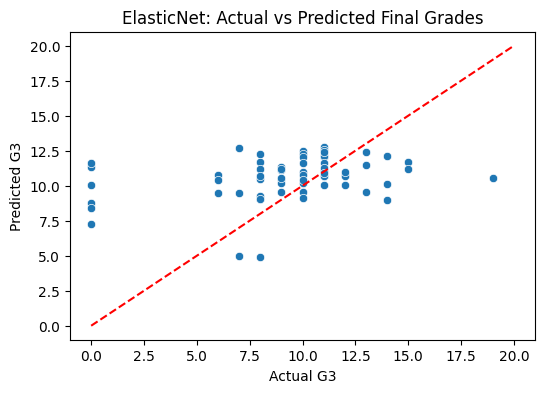

In [ ]:
# Identify best penalized regression model
best_model_name = max(results, key=lambda x: x["Test R2"])["Model"]
print("Best penalized regression model:", best_model_name)

# Refit the best model automatically from GridSearchCV results
pipe_best = GridSearchCV(
    estimator=Pipeline([
        ("preprocess", preprocess),
        ("model", models[best_model_name])
    ]),
    param_grid=param_grids[best_model_name],
    cv=cv,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

pipe_best.fit(X_train, y_train)
y_pred_best = pipe_best.predict(X_test)

# Plot actual vs predicted
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=y_pred_best)
plt.plot([0,20], [0,20], color="red", linestyle="--")
plt.xlabel("Actual G3")
plt.ylabel("Predicted G3")
plt.title(f"{best_model_name}: Actual vs Predicted Final Grades")

# Save the figure in OUTPUT folder
plt.savefig("OUTPUT/ENet_actual_vs_predicted.png", dpi=300, bbox_inches="tight")

plt.show()

## Feature importance plot for elastic net

Elastic Net Feature Importances (sorted by |coefficient|):

schoolsup_yes: -1.0935
Medu: 0.5230
reason_other: 0.4592
activities_yes: -0.3423
Mjob_other: -0.3063
reason_home: -0.2969
Fjob_teacher: -0.2829
guardian_other: 0.2737
traveltime: 0.2713
romantic_yes: 0.2315
famsup_yes: 0.1905
freetime: 0.1778
Mjob_health: -0.1682
Mjob_services: 0.1668
Fjob_other: 0.1596
failures: 0.1507
address_U: 0.1427
studytime: -0.1285
reason_reputation: 0.0922
absences: 0.0795
paid_yes: 0.0703
nursery_yes: -0.0696
famrel: -0.0556
Mjob_teacher: -0.0534
school_MS: -0.0471
Pstatus_T: 0.0468
Dalc: 0.0418
guardian_mother: -0.0404
sex_M: 0.0403
Walc: -0.0200
health: -0.0179
Fjob_services: 0.0147
higher_yes: -0.0065
age: 0.0000
Fedu: 0.0000
Fjob_health: 0.0000
famsize_LE3: -0.0000
goout: -0.0000
internet_yes: 0.0000


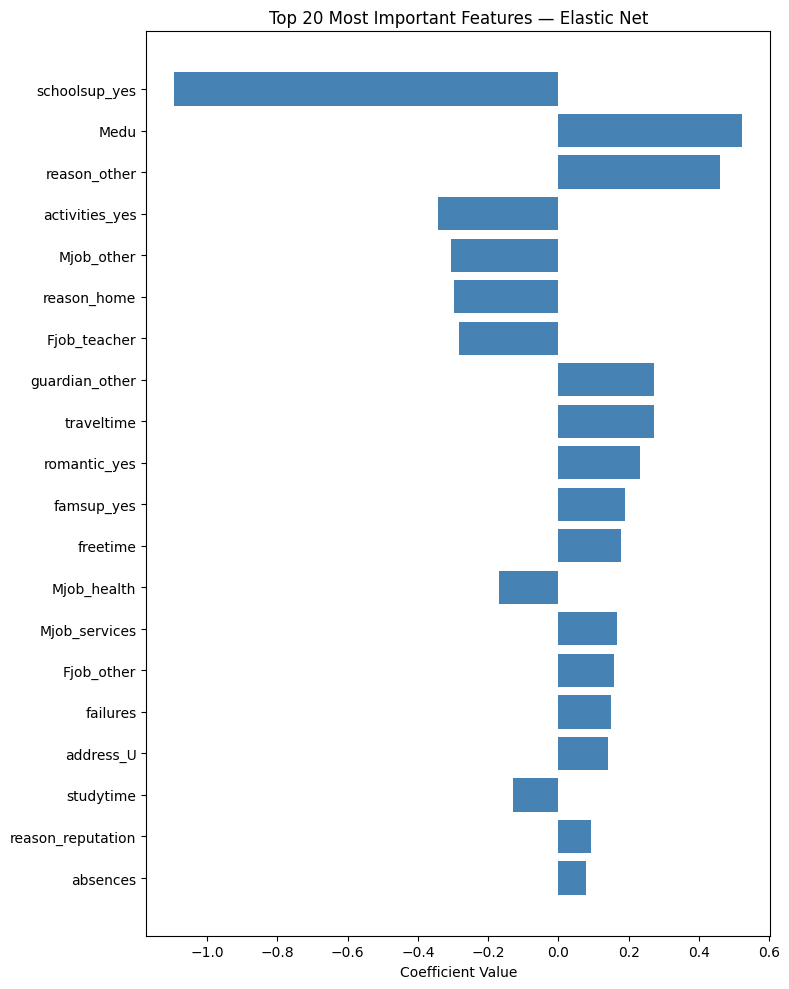

In [ ]:

# Feature Importance for Best Penalized Regression Model (Elastic Net)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Extract the best trained Elastic Net model
best_estimator = pipe_best.best_estimator_
final_model = best_estimator.named_steps["model"]  # ElasticNet

# 2. Extract feature names from preprocessing pipeline
preprocessor = best_estimator.named_steps["preprocess"]

# categorical feature names
cat_encoder = preprocessor.named_transformers_["cat"]
cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)

# numeric feature names
num_feature_names = numeric_cols

# Combine into one ordered feature list
all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

# 3. Create DataFrame of coefficients
coef_df = pd.DataFrame({
    "feature": all_feature_names,
    "coefficient": final_model.coef_
})

# sort by absolute coefficient value (importance)
coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df_sorted = coef_df.sort_values(by="abs_coef", ascending=False)

#PRINT ALL FEATURES AND THEIR COEFFICIENTS
print("Elastic Net Feature Importances (sorted by |coefficient|):\n")
for idx, row in coef_df_sorted.iterrows():
    print(f"{row['feature']}: {row['coefficient']:.4f}")

#PLOT the Top 20 Most Important Features
top20 = coef_df_sorted.head(20)

plt.figure(figsize=(8, 10))
plt.barh(top20["feature"], top20["coefficient"], color="steelblue")
plt.xlabel("Coefficient Value")
plt.title("Top 20 Most Important Features — Elastic Net")
plt.gca().invert_yaxis()
plt.tight_layout()

# Save the figure in OUTPUT folder
plt.savefig("OUTPUT/ENet_features.png", dpi=300, bbox_inches="tight")

plt.show()


### Interpretation
- The largest-magnitude coefficient is schoolsup_yes, which is strongly negative (–1.09), suggesting that students receiving school-provided academic support tend to perform worse. This does not imply the support is harmful; rather, it likely reflects a selection effect, where support is targeted toward students who are already struggling academically. Parental education also emerges as an important predictor: mother’s education (Medu) has a sizable positive coefficient (0.52), indicating that students with more educated mothers tend to earn higher grades, consistent with research linking parental education to educational outcomes. Motivational variables such as reason_other and reason_home also show meaningful effects, implying that the underlying reason for choosing a particular school may reflect differences in family priorities, home environment, or student aspirations that correlate with performance.

- Several behavioral and lifestyle factors also appear influential. Participation in extracurricular activities (activities_yes) has a moderate negative coefficient (–0.34), which may indicate time trade-offs between activities and academic effort. Romantic relationships show a negative association as well, possibly reflecting reduced study time or competing commitments. Variables associated with family support (famsup_yes), free time, and travel time exhibit smaller but noticeable effects, suggesting that time structure and home environment contribute modestly to academic outcomes. Indicators of student difficulty—such as failures—show the expected negative relationship, although their effect size is smaller than hypothesized. Interestingly, studytime has a small negative coefficient (–0.13), which may reflect reverse causality: students who are struggling might increase study time, inflating the observed negative correlation.

- A number of variables, such as parental occupations, alcohol consumption, school choice, and internet access, have near-zero coefficients, indicating limited predictive value in a linear model once other factors are controlled for.
- Overall, the Elastic Net results suggest that
- school support,
- parental education,
- school-choice motivations, and
- certain behavioral factors play the most substantial roles in predicting math performance within a linear framework. These findings also highlight the complexity of educational data, where coefficients may reflect deeper structural patterns, selection effects, or compensatory behaviors rather than simple causal relationships.